## Exercise 1

 - Import Barcelona_air_pollution data
 - Make a descriptive analysis to find the most interessting series to predict, for example you can answer your self if pollution levels are higher or lower during specific year seasons or parts of the day.
 - Train a LSTM NN and use the last 6 months history to validate (3 months) and test (3 months).
 - You can use weather data to improve your modelling and predictions.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
air_pol = pd.read_csv('drive/MyDrive/Barcelona_air_pollution.csv',sep=";")


In [14]:
air_pol

,lon,lat,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,aqi,date,hour,year,city
0,41.3888,2.159,243.66,0.0,0.07,41.84,0.07,5.12,11.97,0.41,1,01/01/2021,0,2021,Barcelona
1,41.3888,2.159,233.65,0.0,0.08,44.35,0.07,5.52,14.40,0.38,1,01/01/2021,1,2021,Barcelona
2,41.3888,2.159,226.97,0.0,0.08,46.49,0.06,5.83,16.02,0.34,1,01/01/2021,2,2021,Barcelona
3,41.3888,2.159,223.64,0.0,0.08,46.49,0.06,6.08,16.92,0.30,1,01/01/2021,3,2021,Barcelona
4,41.3888,2.159,220.30,0.0,0.09,46.49,0.06,6.44,17.89,0.26,1,01/01/2021,4,2021,Barcelona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17324,41.3888,2.159,216.96,0.0,0.07,40.05,0.05,2.71,5.42,0.37,1,31/12/2022,20,2022,Barcelona
17325,41.3888,2.159,216.96,0.0,0.07,38.98,0.05,3.10,6.23,0.40,1,31/12/2022,21,2022,Barcelona
17326,41.3888,2.159,213.62,0.0,0.07,41.13,0.09,4.61,9.95,0.41,1,31/12/2022,22,2022,Barcelona
17327,41.3888,2.159,210.29,0.0,0.06,45.06,0.11,5.32,12.26,0.36,1,31/12/2022,23,2022,Barcelona


In [15]:
air_pol['date_hour0'] = air_pol['date'] + ' ' + air_pol['hour'].astype(str)
air_pol['date_hour'] = pd.to_datetime(air_pol['date_hour0'], format = '%d/%m/%Y %H')
air_pol.drop(['date','hour','date_hour0'], axis = 1, inplace = True)
air_pol.tail(5)

,lon,lat,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,aqi,year,city,date_hour
17324,41.3888,2.159,216.96,0.0,0.07,40.05,0.05,2.71,5.42,0.37,1,2022,Barcelona,2022-12-31 20:00:00
17325,41.3888,2.159,216.96,0.0,0.07,38.98,0.05,3.10,6.23,0.40,1,2022,Barcelona,2022-12-31 21:00:00
17326,41.3888,2.159,213.62,0.0,0.07,41.13,0.09,4.61,9.95,0.41,1,2022,Barcelona,2022-12-31 22:00:00
17327,41.3888,2.159,210.29,0.0,0.06,45.06,0.11,5.32,12.26,0.36,1,2022,Barcelona,2022-12-31 23:00:00
17328,41.3888,2.159,213.62,0.0,0.06,48.64,0.09,4.33,10.00,0.30,1,2023,Barcelona,2023-01-01 00:00:00


In [17]:
weather = pd.read_csv('drive/MyDrive/Barcelona_weather.csv', sep = ';')

weather['date'] = pd.to_datetime(weather['dt'],unit='s')
weather = weather[['date','temp','feels_like','pressure','humidity','wind_speed','dew_point', 'visibility','rain_1h']]
weather['rain_1h'].fillna(0, inplace = True)
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather = weather[weather['year'].isin([2018,2019,2020,2021,2022])]

def nans(df):
  for c in df.columns:
    df[c].bfill(inplace = True)
  return df

weather = nans(weather)

weather.drop_duplicates(inplace = True)
weather.reset_index(inplace = True)
weather.drop(['index'], axis = 1, inplace = True);
weather.head(3)

,date,temp,feels_like,pressure,humidity,wind_speed,dew_point,visibility,rain_1h,year,month
0,2018-01-01 00:00:00,14.63,13.61,1018,56,9.3,5.96,10000.0,0.0,2018,1
1,2018-01-01 01:00:00,13.31,12.05,1019,52,6.7,3.67,10000.0,0.0,2018,1
2,2018-01-01 02:00:00,12.35,11.10,1020,56,6.7,3.83,10000.0,0.0,2018,1


In [18]:
air_pol = air_pol.merge(weather, left_on = 'date_hour', right_on = 'date', how = 'left')
air_pol.columns

Index(['lon', 'lat', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3',
       'aqi', 'year_x', 'city', 'date_hour', 'date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point', 'visibility',
       'rain_1h', 'year_y', 'month'],
      dtype='object')

<Figure size 1200x700 with 0 Axes>

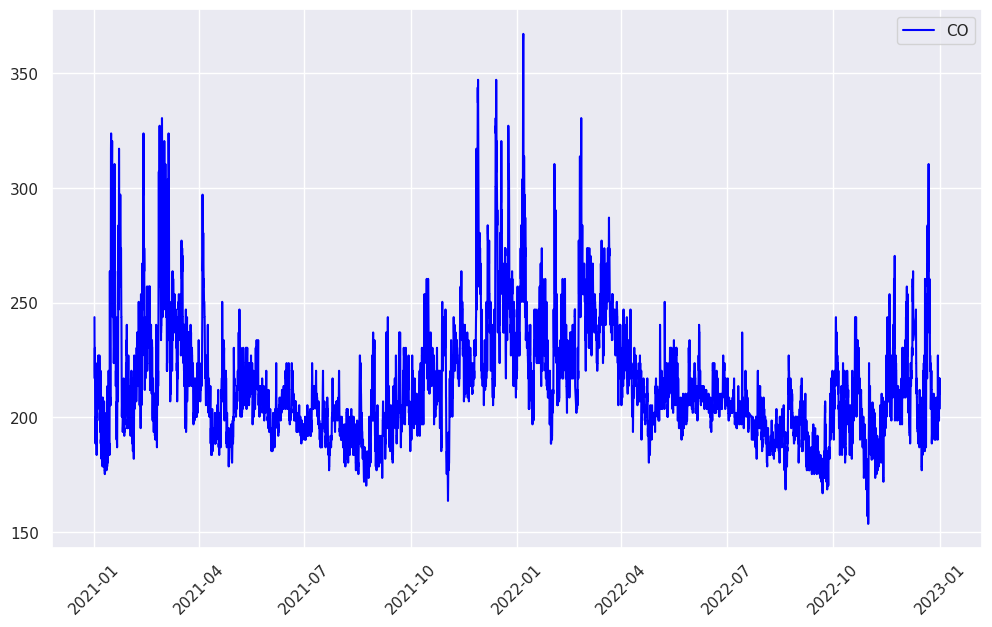

In [19]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
# ax2 = ax.twinx()

ax.plot(air_pol['date_hour'], air_pol['CO'], color = 'blue', label = 'CO')
plt.legend()
plt.xticks(rotation=45);

<Figure size 1200x700 with 0 Axes>

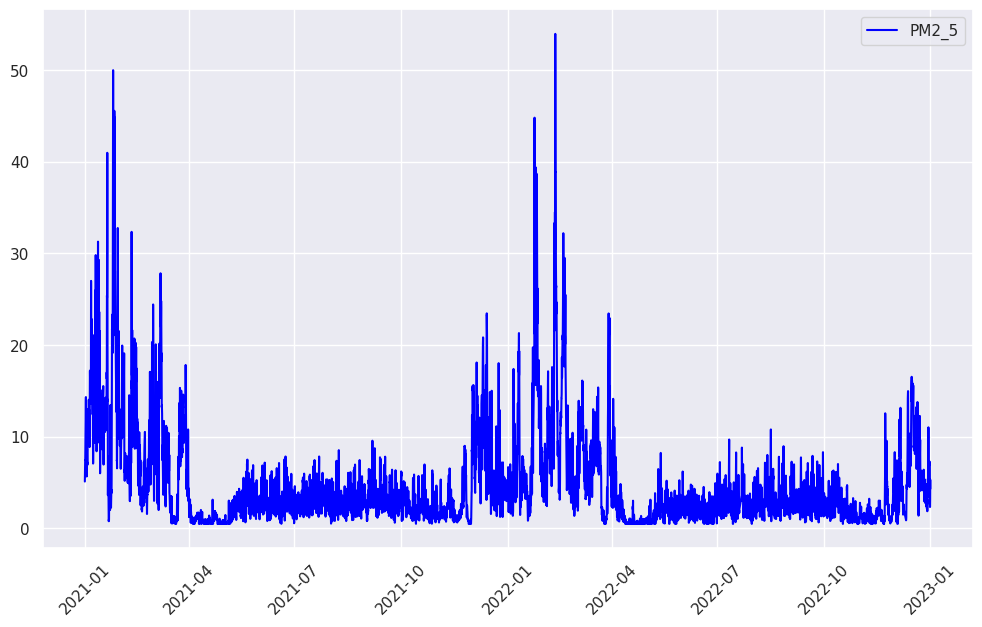

In [20]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
# ax2 = ax.twinx()

ax.plot(air_pol['date_hour'], air_pol['PM2_5'], color = 'blue', label = 'PM2_5')
plt.legend()
plt.xticks(rotation=45);

In [21]:
air_plot_train = air_pol[air_pol['date_hour']<='2022-06-30 23:00:0']
air_plot_val = air_pol[air_pol['date_hour'].between('2022-06-30 23:00:0','2022-09-30 23:00:0')]
air_plot_test = air_pol[air_pol['date_hour']>'2022-09-30 23:00:0']

air_plot_train.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'visibility', 'month'], axis = 1, inplace = True)
air_plot_val.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'visibility', 'month'], axis = 1, inplace = True)
air_plot_test.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'visibility', 'month'], axis = 1, inplace = True)

air_plot_train.columns = ['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']
air_plot_val.columns = ['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']
air_plot_test.columns = ['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']


air_plot_train.head(3)

,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,date,temp,feels_like,pressure,humidity,wind_speed,dew_point
0,243.66,0.0,0.07,41.84,0.07,5.12,11.97,0.41,2021-01-01 00:00:00,9.11,8.43,1007.0,71.0,1.7,4.14
1,233.65,0.0,0.08,44.35,0.07,5.52,14.40,0.38,2021-01-01 01:00:00,8.46,7.31,1006.0,73.0,2.1,3.91
2,226.97,0.0,0.08,46.49,0.06,5.83,16.02,0.34,2021-01-01 02:00:00,8.14,6.94,1006.0,75.0,2.1,3.98


In [54]:
columns_to_use=['NO',"CO", 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']

In [55]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
air_plot_train_scaled = pd.DataFrame(sc.fit_transform(air_plot_train[columns_to_use]),columns=columns_to_use)
air_plot_val_scaled = pd.DataFrame(sc.fit_transform(air_plot_val[columns_to_use]),columns=columns_to_use)
air_plot_test_scaled = pd.DataFrame(sc.fit_transform(air_plot_test[columns_to_use]),columns=columns_to_use)

In [56]:
X_train=air_plot_train_scaled[columns_to_use]
y_train=air_plot_train_scaled["CO"]
X_test=air_plot_test_scaled[columns_to_use]
y_test=air_plot_test_scaled["CO"]
X_val=air_plot_val_scaled[columns_to_use]
y_val=air_plot_val_scaled["CO"]

In [57]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13031, 14) (13031,)
(2138, 14) (2138,)


In [58]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
      v = X.iloc[i:(i + time_steps)].values
      Xs.append(v)
      ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [59]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train_shape, y_train_shape = create_dataset(X_train, y_train, time_steps)
X_test_shape, y_test_shape = create_dataset(X_test, y_test, time_steps)
X_val_shape, y_val_shape = create_dataset(X_val, y_val, time_steps)

print(X_train_shape.shape, y_train.shape)


(13030, 1, 14) (13031,)


In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16,activation='relu', return_sequences = True, input_shape = (X_train_shape.shape[1], X_train_shape.shape[2])),
    tf.keras.layers.LSTM(16,activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
  ])
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history = lstm_model.fit(X_train_shape, y_train_shape, validation_data = (X_val_shape, y_val_shape), epochs=50, batch_size = 100)

ypred_shape = lstm_model.predict(X_test_shape)

_, mae_tr, acc_tr = lstm_model.evaluate(X_train_shape, y_train_shape)
_, mae_ts, acc_ts = lstm_model.evaluate(X_test_shape, y_test_shape)
print('MAE train: %.2f; Acc train: %.2f' % (mae_tr, acc_tr))
print('MAE test: %.2f; Acc test: %.2f' % (mae_ts, acc_ts))

Epoch 1/50
131/131 [==============================] - 5s 22ms/step - loss: 0.0303 - mean_absolute_error: 0.1325 - mean_absolute_percentage_error: 17833.1191 - val_loss: 0.0173 - val_mean_absolute_error: 0.1070 - val_mean_absolute_percentage_error: 213313.9219
Epoch 2/50
131/131 [==============================] - 2s 18ms/step - loss: 0.0069 - mean_absolute_error: 0.0609 - mean_absolute_percentage_error: 13736.9570 - val_loss: 0.0098 - val_mean_absolute_error: 0.0843 - val_mean_absolute_percentage_error: 153190.3750
Epoch 3/50
131/131 [==============================] - 2s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0241 - mean_absolute_percentage_error: 11184.5576 - val_loss: 0.0024 - val_mean_absolute_error: 0.0385 - val_mean_absolute_percentage_error: 69017.0000
Epoch 4/50
131/131 [==============================] - 1s 9ms/step - loss: 5.6148e-04 - mean_absolute_error: 0.0162 - mean_absolute_percentage_error: 5960.4038 - val_loss: 0.0022 - val_mean_absolute_error: 0.0364 - val_mea

## Validation plots

MAPE tan alto supongo por trabajar con valores muy cercanos a 0

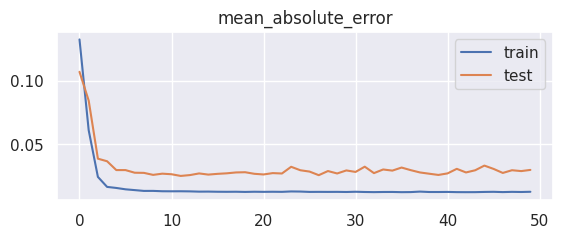

In [63]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='test')
plt.legend()

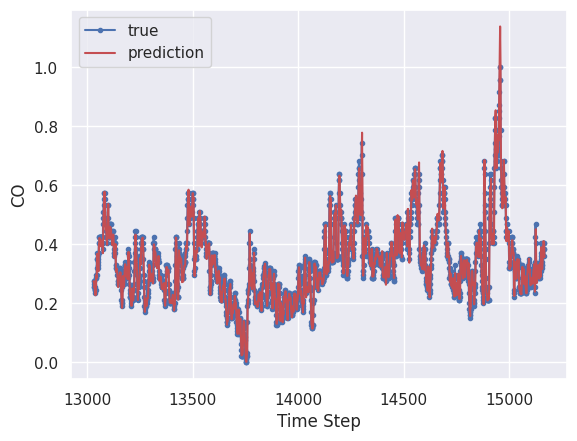

In [64]:
# plt.plot(np.arange(0, len(y_CO_train_shape)), y_CO_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), y_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), ypred_shape.flatten(), 'r', label="prediction")
plt.ylabel('CO')
plt.xlabel('Time Step')
plt.legend()
plt.show();
